In [1]:
!mkdir /content/sample_data/foot_presure
!unzip /content/drive/MyDrive/insole_foot_presure_imagedetect/test.zip -d /content/sample_data/foot_presure/test
!unzip /content/drive/MyDrive/insole_foot_presure_imagedetect/train.zip -d /content/sample_data/foot_presure/train_image
!unzip /content/drive/MyDrive/insole_foot_presure_imagedetect/train_20210106.zip -d /content/sample_data/foot_presure/train_20210106

Archive:  /content/drive/MyDrive/insole_foot_presure_imagedetect/test.zip
   creating: /content/sample_data/foot_presure/test/images/
  inflating: /content/sample_data/foot_presure/test/images/image_0001.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0002.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0003.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0004.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0005.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0006.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0007.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0008.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0009.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0010.png  
  inflating: /content/sample_data/foot_presure/test/images/image_0011.png  
  inflating: /content/sample_d

# Setup

In [2]:
# WandB – Install the W&B library
!pip install wandb -q
!pip install patool
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.6 MB/s eta 0:00:00


In [3]:
from __future__ import print_function
import argparse
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils, models
#ignore excessive warnings
import logging
logging.propagate = False
logging.getLogger().setLevel(logging.ERROR)

import cv2
import wandb

In [8]:
# WandB – Login to your wandb account so you can log all your metrics
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 22
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# prepare dataset

In [9]:
#load datset into Notebook
import patoolib
import pathlib
from pathlib import Path
import shutil


# Source and destination paths
train_source_dir = Path('/content/sample_data/foot_presure/train_image/images')
train_dest_dir = Path('/content/sample_data/foot_presure/train_image')

test_source_dir = Path('/content/sample_data/foot_presure/test/images')
test_dest_dir = Path('/content/sample_data/foot_presure/test')

# Move files from train_source_dir to train_dest_dir
for file_path in train_source_dir.iterdir():
    shutil.move(str(file_path), str(train_dest_dir))

# Move files from test_source_dir to test_dest_dir
for file_path in test_source_dir.iterdir():
    shutil.move(str(file_path), str(test_dest_dir))


In [5]:

#combine new and old train data
def get_new_file_name(file_name):
    file_name = file_name.split('.')
    assert len(file_name) == 2
    return file_name[0] + "_1" + "." + file_name[1]




new_data_path = Path('/content/sample_data/foot_presure/train_20210106')
dest_data_path = Path('/content/sample_data/foot_presure/train_image')


for p in (new_data_path/'images').glob('image_*'):
    p.rename(Path(dest_data_path, get_new_file_name(p.name)))
print(len(list(dest_data_path.glob('image_*'))))


dest_annotation_df= pd.read_csv('/content/sample_data/foot_presure/train_image/annotation.csv')
new_annotation_df  = pd.read_csv('/content/sample_data/foot_presure/train_20210106/annotation.csv')
new_annotation_df['images'] = new_annotation_df['images'].apply(get_new_file_name)
annotation_df = pd.concat([dest_annotation_df, new_annotation_df], ignore_index=True)

test_img_path = Path('/content/sample_data/foot_presure/test')
test_image_names = sorted([p.name for p in test_img_path.glob('image_*')])
test_annotation_df = pd.DataFrame({'images': test_image_names})


1424


In [6]:
#檢測是否正確存入
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):

    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [7]:
train_img_path = Path('/content/sample_data/foot_presure/train_image')
walk_through_dir(train_img_path)
walk_through_dir(test_img_path)

There are 1 directories and 1425 images in '/content/sample_data/foot_presure/train_image'.
There are 0 directories and 0 images in '/content/sample_data/foot_presure/train_image/images'.
There are 1 directories and 1000 images in '/content/sample_data/foot_presure/test'.
There are 0 directories and 0 images in '/content/sample_data/foot_presure/test/images'.


In [10]:
#find block dots for train, valid set

def find_black_dot(img):
  kernel = np.ones((8,8), dtype="float")
  BLACK_THR = 20
  KERNEL_THR = 2.2*5*5 + 1.5*(8*8-5*5)
  img_black = np.sum(img <= BLACK_THR, axis=2)
  img_filtered = cv2.filter2D(img_black, 1, kernel)
  img_dot_mask = img_filtered >= KERNEL_THR
  dot_i, dot_j = np.where(img_dot_mask)
  dot_i, dot_j = int(np.median(dot_i)), int(np.median(dot_j))
  return (dot_j, dot_i)

dot_list = [find_black_dot(io.imread(train_img_path / f)) for f in annotation_df.images]
dot_list_trans = list(zip(*dot_list))
annotation_df['dot_x'] = dot_list_trans[0]
annotation_df['dot_y'] = dot_list_trans[1]
print(annotation_df.head())
print()
# find black dots for test set
print(len(test_image_names))
dot_list = [find_black_dot(io.imread(test_img_path / f)) for f in test_image_names]
dot_list_trans = list(zip(*dot_list))
test_annotation_df['dot_x'] = dot_list_trans[0]
test_annotation_df['dot_y'] = dot_list_trans[1]
print(test_annotation_df.head())


           images  x1   y1  x2   y2  dot_x  dot_y
0  image_0001.png  55  136  75  383     52    275
1  image_0002.png  62  139  42  385     67    286
2  image_0003.png  47  117  76  368     52    254
3  image_0004.png  66  119  37  376     65    246
4  image_0005.png  58  147  85  381     54    276

1000
           images  dot_x  dot_y
0  image_0001.png     58    282
1  image_0002.png     59    279
2  image_0003.png     52    292
3  image_0004.png     65    275
4  image_0005.png     55    267


In [11]:
# 120 * 400 * 3
X_CROP_LOWER, X_CROP_UPPER = (3, 8) # 120
Y_CROP_LOWER, Y_CROP_UPPER = (79, 5) # 400
# note: width of upper and lower should logically be the same
split_crop = {
    'upper': {'x': X_CROP_LOWER, 'y': Y_CROP_LOWER, 'width': 120-X_CROP_LOWER-X_CROP_UPPER, 'height': 120},
    'lower': {'x': X_CROP_LOWER, 'y': 400-Y_CROP_UPPER-75, 'width': 120-X_CROP_LOWER-X_CROP_UPPER, 'height': 95}
}
assert split_crop['upper']['width'] == split_crop['lower']['width']

def check_annotation_range(x1, y1, x2, y2):
    # upper box check
    b = x1 < split_crop['upper']['x'] + split_crop['upper']['width']
    b = b and x1 > split_crop['upper']['x']
    b = b and y1 < split_crop['upper']['y'] + split_crop['upper']['height']
    b = b and y1 > split_crop['upper']['y']
    # lower box check
    b = b and x2 < split_crop['lower']['x'] + split_crop['lower']['width']
    b = b and x2 > split_crop['lower']['x']
    b = b and y2 < split_crop['lower']['y'] + split_crop['lower']['height']
    b = b and y2 > split_crop['lower']['y']
    return b

assert annotation_df['x1'].max() < split_crop['upper']['x'] + split_crop['upper']['width']
assert annotation_df['x1'].min() > split_crop['upper']['x']
assert annotation_df['y1'].max() < split_crop['upper']['y'] + split_crop['upper']['height']
assert annotation_df['y1'].min() > split_crop['upper']['y']
assert annotation_df['x2'].max() < split_crop['lower']['x'] + split_crop['lower']['width']
assert annotation_df['x2'].min() > split_crop['lower']['x']
assert annotation_df['y2'].max() < split_crop['lower']['y'] + split_crop['lower']['height']
assert annotation_df['y2'].min() > split_crop['lower']['y']

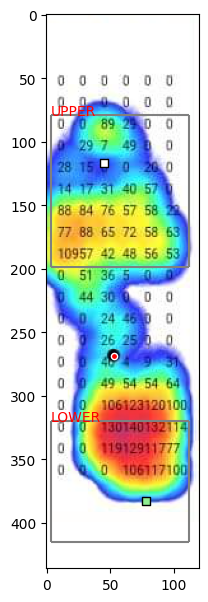

In [12]:
#visualize foot and it's label
def show_foot(image: np.ndarray, annotations: dict=None, predictions: dict=None, black_dot: dict=None, split_crop: dict=None):
    """Show image with landmarks"""
    """split_crop: {'upper': {'x': int, 'y': int, 'width': int, 'height': int}, 'lower': {'x': int, 'y': int, 'width': int, 'height': int}}"""
    plt.figure(figsize = (6.4*1.5,4.8*1.5))
    plt.imshow(image)
    if annotations:
        plt.scatter(annotations['x1'], annotations['y1'], s=30, marker='s', c='white', edgecolors='black')
        plt.scatter(annotations['x2'], annotations['y2'], s=30, marker='s', c='lightgreen', edgecolors='black')
    if predictions:
        if predictions.get('upper') is not None:
            plt.scatter(predictions['upper'][0], predictions['upper'][1], s=15, marker='s', c='gold', edgecolors='black')
        if predictions.get('lower') is not None:
            plt.scatter(predictions['lower'][0], predictions['lower'][1], s=15, marker='s', c='gold', edgecolors='black')
    if black_dot:
        plt.scatter(black_dot['dot_x'], black_dot['dot_y'], s=20, marker='o', c='red', edgecolors='white')
    if split_crop:
        plt.hlines(y = split_crop['upper']['y'],
              xmin = split_crop['upper']['x'],
              xmax = split_crop['upper']['x'] + split_crop['upper']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.hlines(y = split_crop['upper']['y'] + split_crop['upper']['height'],
              xmin = split_crop['upper']['x'],
              xmax = split_crop['upper']['x'] + split_crop['upper']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['upper']['x'],
              ymin = split_crop['upper']['y'],
              ymax = split_crop['upper']['y'] + split_crop['upper']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['upper']['x'] + split_crop['upper']['width'],
              ymin = split_crop['upper']['y'],
              ymax = split_crop['upper']['y'] + split_crop['upper']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.text(x = split_crop['upper']['x'], y = split_crop['upper']['y'], s = 'UPPER', color = 'red')
        #
        plt.hlines(y = split_crop['lower']['y'],
              xmin = split_crop['lower']['x'],
              xmax = split_crop['lower']['x'] + split_crop['lower']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.hlines(y = split_crop['lower']['y'] + split_crop['lower']['height'],
              xmin = split_crop['lower']['x'],
              xmax = split_crop['lower']['x'] + split_crop['lower']['width'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['lower']['x'],
              ymin = split_crop['lower']['y'],
              ymax = split_crop['lower']['y'] + split_crop['lower']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.vlines(x = split_crop['lower']['x'] + split_crop['lower']['width'],
              ymin = split_crop['lower']['y'],
              ymax = split_crop['lower']['y'] + split_crop['lower']['height'],
              colors = 'grey', linestyles = 'solid')
        plt.text(x = split_crop['lower']['x'], y = split_crop['lower']['y'], s = 'LOWER', color = 'red')
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

{'image_0980.png',}
img_name = 'image_0083.png'
img_annotation = annotation_df[annotation_df.images == img_name].to_dict('records')[0]
show_foot(
    io.imread(Path(train_img_path) / img_name),
    annotations = img_annotation,
    black_dot = img_annotation,
    split_crop = split_crop
    )

In [13]:
#transform & create dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class Insolefoot_dataset(Dataset):

  def __init__(self, transforms = None):
    self.annotation_df = annotation_df.copy()
    self.train_img = Path(train_img_path)
    REMOVE_FILES = {'image_0980.png', 'image_0749.png', 'image_0751.png', 'image_0147.png', 'image_0747.png'}
    self.train_img_list = [f for f in sorted(list(self.train_img.glob('image_*'))) if f.name not in REMOVE_FILES]
    self.annotation_df = self.annotation_df[~self.annotation_df['images'].isin(REMOVE_FILES)]
    self.transform = transform

  def update_remove_file(self, file_list):
    self.train_img_list = [f for f in self.train_img_list if f.name not in file_list]
    self.annotation_df = self.annotation_df[~self.annotation_df['images'].isin(file_list)]


  def __len__(self):
    return len(self.train_img_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()[0]
    img_name = self.train_img_list[idx].name
    img_path = self.train_img / img_name
    img_record = self.annotation_df[self.annotation_df.images == img_name].to_dict('records')[0]
    image = io.imread(img_path)
    sample = {'file_name': img_name, 'image': image,
              'dot': np.array([img_record[k] for k in ['dot_x', 'dot_y']])}
    annotations = np.array([img_record[k] for k in ['x1', 'y1', 'x2', 'y2']])
    annotations = annotations.astype('float').reshape(-1, 2)
    sample['annotations'] = annotations
    if self.transform:
      sample['image'] = self.transform(sample['image'])  # Changed from transform to self.transform

    return sample


In [14]:
foot_dataset = Insolefoot_dataset(transforms=transform)
print(len(foot_dataset))
len_valid_set = int(0.1*len(foot_dataset))
len_train_set = len(foot_dataset) - len_valid_set
train_dataset, valid_dataset = torch.utils.data.random_split(foot_dataset, [len_train_set, len_valid_set])


1419


In [15]:
print(len(train_dataset))
print(len(valid_dataset))

1278
141


# Densenet implement

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes=4, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()



    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.in_planes)
        return self.fc(out)




#efficientnet


In [17]:
import torchvision.models as models
class BaseModule(nn.Module):
  def __init__(self, learning_rate=None ):
    super(BaseModule, self).__init__()
    efficientnet_module = models.efficientnet_b0(pretrained=False)
    efficientnet_module_conv = nn.Sequential(*list(efficientnet_module.children())[:-2])
    self.backbone = efficientnet_module_conv

    self.fc = nn.Sequential(
            nn.Linear(66562, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 4))


  def forward(self, img, dot):
    img_conv = self.backbone(img)
    img_conv = img_conv.view(img_conv.size(0), -1)  # Assuming img_conv is of shape [batch_size, 1000]

    # Concatenate img_conv and dot
    concatenated_tensor = torch.cat((img_conv, dot), dim=1)  # Assuming dot is of shape [batch_size, 2]
    #print(self.flatten(img_conv).shape)
    #print(dot.shape)
    out = self.fc(concatenated_tensor)

    return out


In [18]:

from torchinfo import summary
efficientnet_module = models.efficientnet_b0(pretrained=False)
efficientnet_module_conv = nn.Sequential(*list(efficientnet_module.children())[:-2])
summary(model=efficientnet_module_conv,
        input_size=(32, 3, 224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
├─Sequential (0)                                             [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

#Define the Training Loop

In [19]:
def euclidean_distance_loss(prediction, ground_truth):
        diff = prediction.view(-1, 2) - ground_truth.view(-1, 2)
        eu_dist = torch.sqrt(torch.sum(torch.pow(diff, 2), dim=1))
        return torch.mean(eu_dist)

def train(args, model ,device, train_loader, optimizer, epoch):
    model.train()

    for step in range(1, len(train_loader)+1):
      sample = next(iter(train_loader))

      images = sample['image'].cuda()
      dots = sample['dot'].cuda()
      landmarks = sample['annotations'].cuda()
      landmarks = landmarks.view(32,-1)
      print(landmarks)

      predictions = model(images,dots)
      print(predictions)

      optimizer.zero_grad()

      #print("pre shape: ", predictions.shape)
      #print("landmarks sahpe: ", landmarks.shape)
      loss_train_step = euclidean_distance_loss(predictions, landmarks)
      loss_train_step.backward()

      optimizer.step()







In [23]:
def test(args, model, device, test_loader, classes):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.eval()
    loss_test = 0
    correct = 0

    example_images = []
    with torch.no_grad():
      for step in range(1, len(test_loader)+1):
        sample = next(iter(test_loader))
        images = sample['image'].cuda()
        dots = sample['dot'].cuda()
        landmarks = sample['annotations'].cuda()
        landmarks = landmarks.view(32, -1)


        predictions = model(images,dots)


        loss_test_step = nn.MSELoss()(predictions, landmarks)
        loss_test += loss_test_step.item()
        running_loss = loss_test/step

        # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
        example_images.append(wandb.Image(
                images, caption={"Prediction": {
                                  "labels": [
                                      {
                                          "position":{"x1":predictions[0][0],"y1": predictions[0][1],
                                                      "x2":predictions[0][2],"y2":predictions[0][3]}
                                          }
                                  ]}
                }))


    # WandB – wandb.log(a_dict) logs the keys and values of the dictionary passed in and associates the values with a step.
    # You can log anything by passing it to wandb.log, including histograms, custom matplotlib objects, images, video, text, tables, html, pointclouds and other 3D objects.
    # Here we use it to log test accuracy, loss and some test images (along with their true and predicted labels).
    wandb.log({
        "Examples": example_images,
        "Test Accuracy": 100. * correct / len(test_loader.dataset),
        "Test Loss": loss_test})

In [24]:

# WandB – Initialize a new run
wandb.init(project="insole_foot_presure")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 32       # input batch size for training (default: 64)
config.test_batch_size = 32   # input batch size for testing (default: 1000)
config.epochs = 10             # number of epochs to train (default: 10)
config.lr = 0.1               # learning rate (default: 0.01)
config.momentum = 0.1          # SGD momentum (default: 0.5)
config.no_cuda = False         # disables CUDA training
config.seed = 42               # random seed (default: 42)
config.log_interval = 10     # how many batches to wait before logging training status

def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Now we load our training and test datasets and apply the transformations defined above
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size,
                                              shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.test_batch_size,
                                             shuffle=False, **kwargs)

    classes = ('x1', 'y1', 'x2', 'y2')

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    model = BaseModule(learning_rate = config.lr).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        test(config, model, device, test_loader, classes)

    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
    torch.save(model.state_dict(), "model.h5")
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

Test Accuracy,▁▁▁▁▁▁▁▁▁▁
Test Loss,█▁▁▁▁▁▁▁▁▁
Test Accuracy,0.0
Test Loss,685.08196


串流輸出內容已截斷至最後 5000 行。
        [ 56., 136.,  53., 353.],
        [ 51., 107.,  38., 380.],
        [ 50., 138.,  30., 374.],
        [ 56., 119.,  76., 384.],
        [ 51., 123.,  68., 370.],
        [ 61., 133.,  23., 382.],
        [ 58., 133.,  30., 382.],
        [ 70., 140.,  80., 385.],
        [ 59., 154.,  82., 384.],
        [ 55., 124.,  78., 378.],
        [ 62., 141.,  45., 370.],
        [ 58., 144.,  28., 384.],
        [ 49., 171.,  26., 382.],
        [ 61., 127.,  30., 376.],
        [ 58., 140.,  40., 367.],
        [ 63., 105.,  33., 379.],
        [ 60., 109.,  24., 384.],
        [ 54., 144.,  25., 367.],
        [ 50., 137.,  82., 382.],
        [ 59., 117.,  23., 385.],
        [ 53., 146.,  25., 383.],
        [ 52., 133.,  80., 366.],
        [ 62., 107.,  27., 373.],
        [ 56., 134.,  23., 382.],
        [ 62., 135.,  80., 383.],
        [ 65., 153.,  77., 372.],
        [ 61., 142.,  28., 380.]], device='cuda:0', dtype=torch.float64)
tensor([[ 60.8485, 133